# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка.  
Цель исследования — определение влияния семейного положения, количества детей, уровня дохода клиента и целей займа на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.  
Таблица седержит следующие данные:
- children — количество детей в семье;
- days_employed — общий трудовой стаж в днях;
- dob_years — возраст клиента в годах;
- education — уровень образования клиента;
- education_id — идентификатор уровня образования;
- family_status — семейное положение;
- family_status_id — идентификатор семейного положения;
- gender — пол клиента;
- income_type — тип занятости;
- debt — имел ли задолженность по возврату кредитов;
- total_income — ежемесячный доход;
- purpose — цель получения кредита.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

Содержание исследования:
1. [Открытие файла с данными и ознакомление с общей информацией](#open_file)
2. [Предобработка данных](#data_preprocessing)  
 2.1.[Обработка пропусков](#processing_nan)  
 2.2. [Замена типа данных](#change_type)  
 2.3. [Обработка некорректных данных](#duplicates)  
    * [Обработка данных столбца "children" (количество детей в семье)](#duplicates_children)
    * [Обработка данных столбца "dob_years" (возраст клиента в годах)](#duplicates_years)
    * [Обработка данных столбца "gender" (пол клиента)](#duplicates_gender)
    * [Обработка данных столбца "education" (уровень образования клиента)](#duplicates_education)
  
 2.4. [Лемматизация](#lemma)  
 2.5. [Категоризация данных](#categorization)  
    * [Категоризация данных столбца "debt" (имел ли задолженность по возврату кредитов)](#categorization_debt)
    * [Категоризация данных столбца "children" (количество детей в семье)](#categorization_children)
    * [Категоризация данных столбца "family_status" (семейное положение)](#categorization_family_status)
    * [Категоризация данных столбца "purpose" (цель получения кредита)](#categorization_purpose)
    * [Категоризация данных столбца "total_income" (ежемесячный доход)](#categorization_total_income)
3. [Исследование зависимости просрочек платежей от характеристик заемщика](#research)  
 3.1. [Зависимость просрочек платежей от количества детей](#children)  
 3.2. [Зависимость просрочек платежей от семейного статуса](#family_status)  
 3.3. [Зависимость просрочек платежей от уровня дохода](#incom)  
 3.4. [Зависимость просрочек платежей от целей кредита](#purpose)
4. [Общий вывод](#result)

## Открытие файла с данными и ознакомление с общей информацией.
<a id="open_file"></a>

Импортируем необходимые для исследования библиотеки:

In [1]:
import pandas                      # импортируем библиотеку pandas (для работы с DataFrame)
import numpy as np
import seaborn as sns              # импортируем библиотеку sns (для создания диаграмм)
from pymystem3 import Mystem       # импортируем модуль Mystem библиотеки pymystem3 (для лемматизации)
m = Mystem()
from collections import Counter    # импортируем модуль Counter библиотеки collections (для лемматизации)
import matplotlib.pyplot as plt    # импортируем библиотеку matplotlib.pyplot (для редактирования свойств диаграмм)

Читаем файл "data.csv" в таблицу "data":

In [2]:
data = pandas.read_csv('/datasets/data.csv')  # считываем файл "data.csv" в таблицу "data"       

Выводим общие сведения о таблице:

In [3]:
data.info(memory_usage='deep')                # выводим на экран общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 11.3 MB


Выводим на экран первые 15 значений таблицы "data":

In [4]:
data.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Выводим на экран последние 15 значений таблицы "data":

In [5]:
data.tail(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21510,2,NaN,28,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,приобретение автомобиля
21511,0,-612.569129,29,высшее,0,гражданский брак,1,F,сотрудник,1,140068.472941,покупка жилья для сдачи
21512,0,-165.377752,26,высшее,0,Не женат / не замужем,4,M,компаньон,0,147301.457769,получение дополнительного образования
21513,0,-1166.216789,35,среднее,1,женат / замужем,0,F,сотрудник,0,250986.142309,покупка жилья
21514,0,-280.469996,27,неоконченное высшее,2,Не женат / не замужем,4,M,компаньон,0,355988.407188,строительство недвижимости
21515,1,-467.685130,28,среднее,1,женат / замужем,0,F,сотрудник,1,109486.327999,заняться образованием
21516,0,-914.391429,42,высшее,0,женат / замужем,0,F,компаньон,0,322807.776603,покупка своего жилья
21517,0,-404.679034,42,высшее,0,гражданский брак,1,F,компаньон,0,178059.553491,на покупку своего автомобиля
21518,0,373995.710838,59,СРЕДНЕЕ,1,женат / замужем,0,F,пенсионер,0,153864.650328,сделка с автомобилем
21519,1,-2351.431934,37,ученая степень,4,в разводе,3,M,сотрудник,0,115949.039788,покупка коммерческой недвижимости


Выводим на экран выборку из 15 случайных значений таблицы "data":

In [6]:
data.sample(n = 15, random_state = 0)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
7340,2,-3818.249310,39,среднее,1,женат / замужем,0,F,сотрудник,0,40930.315696,покупка жилья
3957,0,-12111.680981,47,среднее,1,женат / замужем,0,F,компаньон,0,108406.132467,покупка коммерческой недвижимости
6605,0,-3617.168602,48,среднее,1,Не женат / не замужем,4,M,сотрудник,1,214785.654014,получение высшего образования
14910,0,NaN,20,среднее,1,Не женат / не замужем,4,M,сотрудник,0,NaN,покупка жилой недвижимости
763,0,NaN,21,среднее,1,гражданский брак,1,M,компаньон,0,NaN,покупка жилья
3047,1,-600.374201,36,высшее,0,женат / замужем,0,F,компаньон,0,254378.958759,заняться высшим образованием
17714,1,-237.949278,31,Среднее,1,Не женат / не замужем,4,M,сотрудник,1,148067.024645,свой автомобиль
5418,1,-1177.598475,30,среднее,1,женат / замужем,0,M,сотрудник,0,74136.414902,автомобиль
21158,1,-8243.628440,43,среднее,1,женат / замужем,0,M,сотрудник,0,161158.587768,покупка жилья для сдачи
21000,2,NaN,35,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,покупка жилья


Выводим на экран описательную статистику для строковых значений:

In [7]:
data.describe(include=['object']).T

,count,unique,top,freq
education,21525,15,среднее,13750
family_status,21525,5,женат / замужем,12380
gender,21525,3,F,14236
income_type,21525,8,сотрудник,11119
purpose,21525,38,свадьба,797


Выводим на экран описательную статистику для числовых значений:

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
children,21525.0,0.538908,1.381587,-1.000000,0.000000,0.000000,1.000000,2.000000e+01
days_employed,19351.0,63046.497661,140827.311974,-18388.949901,-2747.423625,-1203.369529,-291.095954,4.017554e+05
dob_years,21525.0,43.293380,12.574584,0.000000,33.000000,42.000000,53.000000,7.500000e+01
education_id,21525.0,0.817236,0.548138,0.000000,1.000000,1.000000,1.000000,4.000000e+00
family_status_id,21525.0,0.972544,1.420324,0.000000,0.000000,0.000000,1.000000,4.000000e+00
debt,21525.0,0.080883,0.272661,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_income,19351.0,167422.302208,102971.566448,20667.263793,103053.152913,145017.937533,203435.067663,2.265604e+06


Выводим на экран уникальные значения столбцов, за исключением данных из столбцов "days_employed" (общий трудовой стаж в днях) и "total_income": они могут принимать любые значения, их уникальность для исследования ценности не имеет:

In [9]:
def unique_data(columns):      # объявляем функцию "unique_data"
    for i in columns:          # проходим циклом по значениям колонок
        m = data[i].unique()   # находим уникальные значения в каждом столбце
        m.sort()               # сортируем уникальные значения
        print(f'{i}',m)        # выводим на экран уникальные значения
        print()
    return 'end'

In [10]:
columns_all_unique = ['children', 'dob_years', 'education', 'education_id', 'family_status', 'family_status_id',
                      'gender', 'income_type', 'debt', 'purpose']
unique_data(columns_all_unique)         # вызываем функцию "unique_data" и выводим результат ее работы

children [-1  0  1  2  3  4  5 20]

dob_years [ 0 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75]

education ['ВЫСШЕЕ' 'Высшее' 'НАЧАЛЬНОЕ' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Начальное'
 'Неоконченное высшее' 'СРЕДНЕЕ' 'Среднее' 'УЧЕНАЯ СТЕПЕНЬ'
 'Ученая степень' 'высшее' 'начальное' 'неоконченное высшее' 'среднее'
 'ученая степень']

education_id [0 1 2 3 4]

family_status ['Не женат / не замужем' 'в разводе' 'вдовец / вдова' 'гражданский брак'
 'женат / замужем']

family_status_id [0 1 2 3 4]

gender ['F' 'M' 'XNA']

income_type ['безработный' 'в декрете' 'госслужащий' 'компаньон' 'пенсионер'
 'предприниматель' 'сотрудник' 'студент']

debt [0 1]

purpose ['автомобили' 'автомобиль' 'высшее образование'
 'дополнительное образование' 'жилье' 'заняться высшим образованием'
 'заняться образованием' 'на покупку автомобиля'
 'на покупку подержанного автомобиля' 'на покупку своег

'end'

Проверяем столбцы на пропуски:

In [11]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

**Вывод**  
Из полученной информации видны следующие проблемы в данных:
1. В таблице "data" 21525 строк. В столбцах "days_employed" (общий трудовой стаж в днях) и "total_income" (ежемесячный доход) 2174 пустых ячеек.
2. Столбцы имеют следующие типы: "float64"(2), "int64"(5), "object"(5). При этом столбцы "days_employed" (общий трудовой стаж в днях) и "total_income" (ежемесячный доход) имеют тип 'float'. Для анализа желательно перевести значения данных столбцов в целочисленные.
3. В столбце "days_employed" (общий трудовой стаж в днях) присутствуют как положительные, так и отрицательные значения. 
4. В столбце "days_employed" (общий трудовой стаж в днях) приведенные к годам значения лежат в диапазоне 0,41-932. Очевидно, что трудовой стаж не может быть достигать 932 лет. Вероятно, данные вносились в разных форматах - часы, дни, месяцы. Поскольку приведение значений в столбце "days_employed" (общий трудовой стаж в днях) трудоемко, а для ответа на поставленные перед исследователем вопросы они ценности не имеют, то устранение данного недочета опускаем.
5. В столбце "education" (уровень образования клиента) присутствуют данные в как в верхнем, так и нижнем регистрах.
6. В столбце "purpose" (цель получения кредита) присутствуют данные, одинаковые по сути, но отличающиеся в форме, например "сыграть свадьбу" и "на проведение свадьбы".
7. В столбце "children" (количество детей в семье) присутствует отрицательное значение "-1".
8. В столбце "children" (количество детей в семье) имеются значения 20 - значительно превышает другие значения.
9. В столбце "dob_years" (возраст клиента в годах) указан возраст "0".
10. В столбце "gender" () присутствует неопределенное значение "XNA".

## Предобработка данных.
<a id="data_preprocessing"></a>

### Обработка пропусков.
<a id="processing_nan"></a>

Пропуски присутствуют в столбцах "days_employed" (общий трудовой стаж в днях) и "total_income" (ежемесячный доход) - по 2174 в каждом.
Готовим данные для обработки пропусков - берем значения по модулю:

In [12]:
try:
    data['days_employed'] = data['days_employed'].abs()    # берем значения по модулю
    data['total_income'] = data['total_income'].abs()      # берем значения по модулю
except:
    print('Некорректный тип данных')

Заполняем пропуски в столбцах "days_employed" (общий трудовой стаж в днях) и "total_income" (ежемесячный доход) значениями медиан, вычисленных для каждого из типа занятости (столбец "income_type"):

In [13]:
columns_nan_list = ['days_employed', 'total_income']       # список столбцов, содержащих пустые ячейки
income_type_unique = data['income_type'].unique()          # список уникальных значений столбца "income_type"
for i in columns_nan_list:                                 # проходим циклом по списку столбцов, содержащих пустые ячейки
    # проходим циклом по списку уникальных значений столбца "income_type"
    for j in income_type_unique:
        # заменяем пропуски на медианы
        data.loc[(data[i].isna()) & (data['income_type'] == j), i] = data.loc[data['income_type'] == j, i].median()

Проверяем таблицу "data" на пропуски:

In [14]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**  
В исходной таблице "data" данные по стажу и доходу отсутствуют у одних и тех же клиентов. Это может быть вызвано тем, что клиенты не могут подтвердить их документально, то есть не трудоустроены официально.  
Пропущенные значения заменены медианами, вычисленными для каждого из типа занятости (столбец "income_type").

### Замена типа данных.
<a id="change_type"></a>

Таблица состоит из строковых и чистовых значений. Значения столбцов "education", "family_status", "purpose", "income_type" и "gender" являются категориальными, имеют тип "object" (строковые). Для экономии ресурсов целесообразно заменить их тип на "category". Однако в "education" и "gender" присутствуют некорректные значения, поэтому изменение их типа допустимо только после приведения данных в надлежащий вид.  
В столбце "purpose" хранятся 37 категориальных значений. Поскольку эти данные предназначены для лемматизации, а сами правиться не будут, то возможно им также сменить тип на "category".  
Изменяем тип данных столбцов "family_status", "income_type" и "purpose":

In [15]:
try:
    data['family_status'] = data['family_status'].astype('category')
    data['income_type'] = data['income_type'].astype('category')
    data['purpose'] = data['purpose'].astype('category')
except:
    print('Некорректный тип данных')

Данные столбцов , "dob_years", "education_id", "family_status_id" и "debt" имеют тип "int64" (размер числа - 8 байт). Поскольку значения целочисленные, положительные и попадают в диапазон 0 - 255, целесообразно заменить тип на "uint8" (размер числа - 1 байт). После корректировки данных, к этому же типу будут приведены также значения "children".  
Изменяем тип данных столбцов "dob_years", "education_id" и "family_status_id" и "debt":

In [16]:
try:
    data['dob_years'] = data['dob_years'].astype('uint8')
    data['education_id'] = data['education_id'].astype('uint8')
    data['family_status_id'] = data['family_status_id'].astype('uint8')
    data['debt'] = data['debt'].astype('uint8')
except:
    print('Некорректный тип данных')

Данные столбцов "days_employed" и "total_income" также имеют тип "int64" (размер числа - 8 байт). Они также целочисленные и положительные, но диапазон их значений намного шире. Для них заменяем тип на "uint32" (размер числа - 4 байт):

In [17]:
try:
    data['days_employed'] = data['days_employed'].astype('uint32')
    data['total_income'] = data['total_income'].astype('uint32')
except:
    print('Некорректный тип данных')

Выводим общие сведения о таблице:

In [18]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   children          21525 non-null  int64   
 1   days_employed     21525 non-null  uint32  
 2   dob_years         21525 non-null  uint8   
 3   education         21525 non-null  object  
 4   education_id      21525 non-null  uint8   
 5   family_status     21525 non-null  category
 6   family_status_id  21525 non-null  uint8   
 7   gender            21525 non-null  object  
 8   income_type       21525 non-null  category
 9   debt              21525 non-null  uint8   
 10  total_income      21525 non-null  uint32  
 11  purpose           21525 non-null  category
dtypes: category(3), int64(1), object(2), uint32(2), uint8(4)
memory usage: 4.0 MB


***Вывод***  
В результате оптимизации типов данных "family_status", "income_type", "purpose", "dob_years", "education_id" , "family_status_id debt", "days_employed" и "total_income" удалось сократить объем используемой памяти на 65% - с 11,3 до 4,0 МБ. Для данных "education", "gender" и "children" типы будут оптимизированы после их обработки.

### Обработка некорректных данных
<a id="duplicates"></a>

***Обработка данных столбца "children" (количество детей в семье)***
<a id="duplicates_children"></a>

В столбце "children" (количество детей в семье) содержатся значения "-1" и "20".  
Переводим все значения столбца "children" (количество детей в семье) в положительные:

In [19]:
data['children'] = data['children'].abs()

Проверяем значения столбца "children" (количество детей в семье):

In [20]:
data['children'].value_counts()

0     14149
1      4865
2      2055
3       330
20       76
4        41
5         9
Name: children, dtype: int64

Значение "-1" исправлено.  
Однако в столбце "children" (количество детей в семье) присутствует исключительно большое значение - "20": в России рекорд по количеству детей принадлежит семье Шишкиных из Воронежской области - 20 детей. Но в таблице "data" обозначены 76 клиентов с количеством детей "20", что свидетельствует о некорректности данных.  
Поскольку в данном проекте определяется в том числе зависимость просрочек платежей по кредиту от количества детей, и при этом нет критерия, по которому можно однозначно определить относится "20" скорее к "2" или к "0", исключаем эти данные из расчета:

In [21]:
data = data.loc[data['children'] < 20].reset_index(drop=True)

Проверяем данные в столбце "children" (количество детей в семье):

In [22]:
data['children'].value_counts()

0    14149
1     4865
2     2055
3      330
4       41
5        9
Name: children, dtype: int64

Изменяем тип данных на "uint8" (размер числа - 1 байт)

In [23]:
data['children'] = data['children'].astype('uint8')

***Вывод***  
Исследование показало, что в столбце "children" (количество детей в семье) присутствуют некорректные значения - "-1" и "20".  
Вероятно, попадание в таблицу значения "-1" - следствие человеческого фактора: при анкетировании было занесено через тире. Так же причина может крыться в техническом сбое: тире проставлено только у единицы. Значение "-1" заменено на "1".  
Значение "20" встречается в столбце "children" (количество детей в семье) 76 раз, что не соответствует статистике по многодетным семьям. Возможно, ошибка возникла при внесении либо значения "2", либо "0". Вероятно, это следствие технического сбоя. Если бы причиной был человеческий фактор, то присутствовали бы опечатки вроде "30", "40" и т.д. Но в столбце присутствуют только "20".  
В целях экономии ресурсов тип значений изменен с "int64" (размер числа - 8 байт) на "uint8" (размер числа - 1 байт).

***Обработка данных столбца "dob_years" (возраст клиента в годах)***
<a id="duplicates_years"></a>

Судя по полученной из таблицы "data" информации, банковская организация предоставляет кредиты только совершеннолетним: минимальный возраст заемщиков - 19 лет. При этом у некоторых пользователей указан возраст "0", что однозначно говорит о некорректности этих значений.  
Значения возраста, которые меньше "18", заменяем на медианы, вычисленные в соответствии с типом занятости (столбец "income_type"):

In [24]:
for i in income_type_unique:
    data.loc[(data['dob_years'] < 18) & (data['income_type'] == i), 'dob_years'] = data.loc[data['income_type'] == i, 'dob_years'].median().astype('uint8')

Проверяем, остались ли в столбце "dob_years" (возраст клиента в годах) значения меньше 18.

In [25]:
'Количество несовершеннолетних клиентов: {}'.format(data.loc[data['dob_years'] < 18]['dob_years'].count())

'Количество несовершеннолетних клиентов: 0'

***Вывод***  
В исходной таблице "data" присутствуют некорректные значения столбца "dob_years" (возраст клиента в годах) - "0". Поскольку возраст - один из основных параметров, влияющих на решение по одобрению кредита, то маловероятно, что в систему изначально были внесены некорректные данные. Вероятно, сбой произошел при дальнейшей обработке информации: копировании, сохранении, переводе файла из в другой формат и т.д.  
Судя по информации из таблицы, минимальный возраст заемщика - 19 лет. Для всех клиентов, у которых возраст указан меньше 18, заменяем значения на медианы, вычисленные в соответствии с типом занятости (столбец "income_type"). Для более точной установки фильтра желательно уточнить у заказчика исследования минимальный возраст предоставления кредита (на случай обновления исходных данных). 

***Обработка данных столбца "gender" (пол клиента)***
<a id="duplicates_gender"></a>

В столбце "gender" (пол клиента) содержится некорректное указание пола заемщика - "XNA".  
Выводим на экран уникальные значения столбца "gender" (пол клиента) и их количество:

In [26]:
data['gender'].value_counts()

F      14189
M       7259
XNA        1
Name: gender, dtype: int64

В столбце единожды встречается значение "XNA". Заменим его на корректное, встречающееся наиболее часто, - на "F":

In [27]:
data['gender'] = data['gender'].replace('XNA', 'F')

Проверяем значения в столбце "gender" (пол клиента):

In [28]:
data['gender'].value_counts()

F    14190
M     7259
Name: gender, dtype: int64

Изменяем тип данных на "category":

In [29]:
data['gender'] = data['gender'].astype('category')

***Вывод***
В исходной таблице "data" единожды встречается значение пола "XNA". Маловероятно внесение столь неопределенной информации клиентом или сотрудником кредитной организации: заявка на кредит, скорее всего, не прошла бы согласование. К тому же однозначно идентифицировать пол данного клиента не представляется возможным: сочетание символов ни на русской раскладке клавиатуры, на английской не дает исчерпывающей информации. Вероятно, ошибка стала результатом технического сбоя.  
Поскольку данные о поле клиента в исследовании не используются, заменяем значение "XNA" на корректное, встречающееся наиболее часто, - на "F".  
В целях экономии ресурсов тип значений изменен с "object" на "category".

***Обработка данных столбца "education" (уровень образования клиента)***
<a id="duplicates_education"></a>

Дубликаты присутствуют в строковых данных столбца "education" (уровень образования клиента).  
Поскольку дубликаты неявные, возникшие в результате использования символов различных регистров, приводим значения к единому формату методом "str.lower()":

In [30]:
data['education'] = data['education'].str.lower()

Проверяем текстовые значения на дубликаты:

In [31]:
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Изменяем тип данных на "category":

In [32]:
data['education'] = data['education'].astype('category')

***Вывод***  
В столбце "education" (уровень образования клиента) присутствуют неявные дубликаты: используются символы как верхнего, так и нижнего регистра. Вероятно, в анкете свободная форма заполнения соответствующего поля.
Все символы значений столбца "education" (уровень образования клиента) приведены к нижнему регистру, неявное дублирование устранено.  
В целях экономии ресурсов тип значений изменен с "object" на "category".

### Лемматизация
<a id="lemma"></a>

В столбце "purpose" (цель получения кредита) содержатся строковые данные, различные по форме, но являющимися дублями по смыслу. Определяем перечень лемм в данном столбце и частоту их использования.  
На основе уникальных значений столбца "purpose" (цель получения кредита) производим лемматизацию целей кредита:

In [33]:
purpose_unique = data['purpose'].unique()
purpose_lemma = []
for i in purpose_unique:
    lemmas = m.lemmatize(i)
    for j in lemmas:
        purpose_lemma.append(j)
Counter(purpose_lemma)

Counter({'покупка': 10,
         ' ': 59,
         'жилье': 7,
         '\n': 38,
         'приобретение': 1,
         'автомобиль': 9,
         'дополнительный': 2,
         'образование': 9,
         'сыграть': 1,
         'свадьба': 3,
         'операция': 4,
         'с': 5,
         'на': 4,
         'проведение': 1,
         'для': 2,
         'семья': 1,
         'недвижимость': 10,
         'коммерческий': 2,
         'жилой': 2,
         'строительство': 3,
         'собственный': 1,
         'подержать': 1,
         'свой': 4,
         'со': 1,
         'заниматься': 2,
         'сделка': 2,
         'подержанный': 1,
         'получение': 3,
         'высокий': 3,
         'профильный': 1,
         'сдача': 1,
         'ремонт': 1})

***Вывод***  
В столбце "purpose" (цель получения кредита) исходной таблицы "data" присутствуют неявные дубликаты: есть группы данных, схожих по содержанию, но различных по форме. Вероятно, в анкете свободная форма заполнения соответствующего поля.  
По результатам лемматизации и сопоставления их с перечнем уникальных значений столбца "purpose" (цель получения кредита) выделяем 4 основные цели кредита - "недвижимость", "автомобиль", "образование" и "свадьба".

### Обработка выбросов

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21449 entries, 0 to 21448
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   children          21449 non-null  uint8   
 1   days_employed     21449 non-null  uint32  
 2   dob_years         21449 non-null  uint8   
 3   education         21449 non-null  category
 4   education_id      21449 non-null  uint8   
 5   family_status     21449 non-null  category
 6   family_status_id  21449 non-null  uint8   
 7   gender            21449 non-null  category
 8   income_type       21449 non-null  category
 9   debt              21449 non-null  uint8   
 10  total_income      21449 non-null  uint32  
 11  purpose           21449 non-null  category
dtypes: category(5), uint32(2), uint8(5)
memory usage: 379.4 KB


Проверяем на выбросы. Если значения не попадают в диапазон от Q1-3IQR до Q3+3IQR - удаляем соответствующие строки:

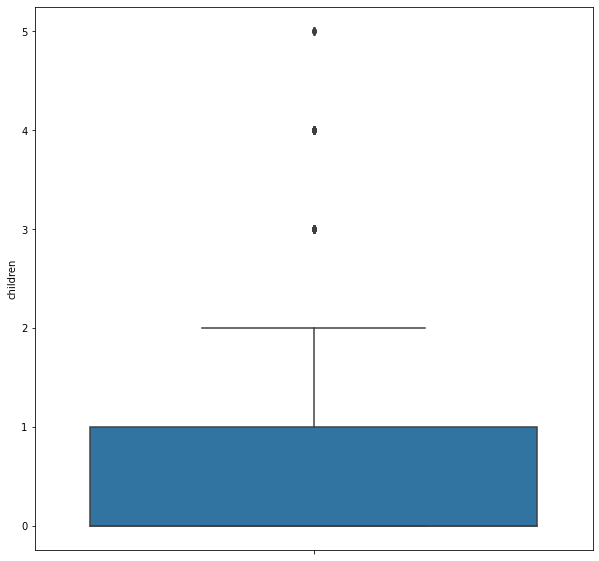

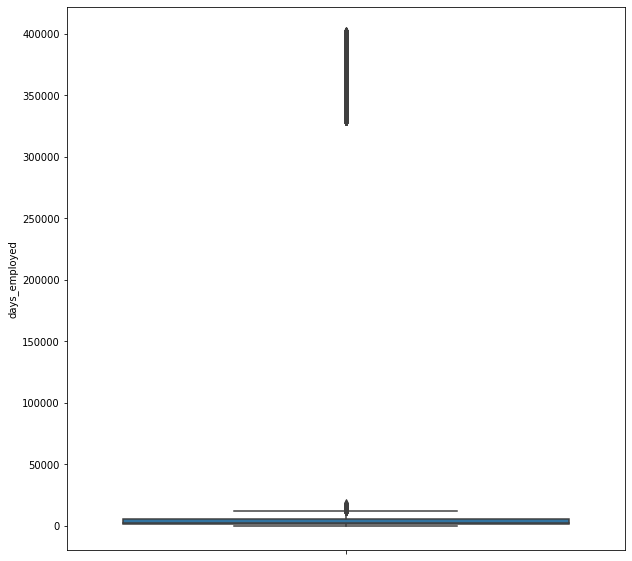

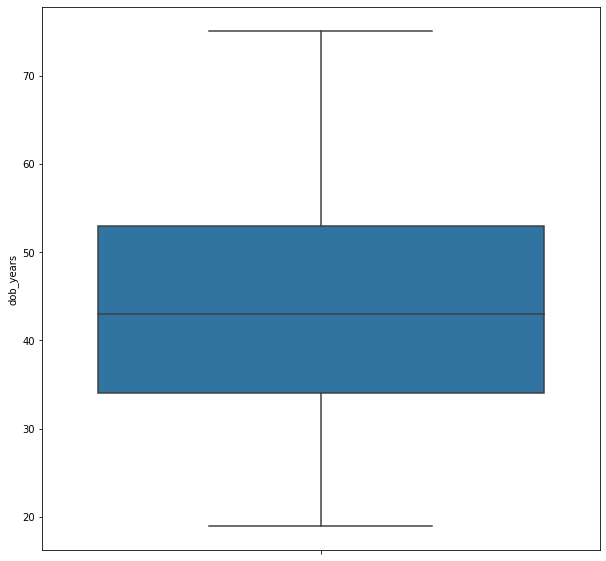

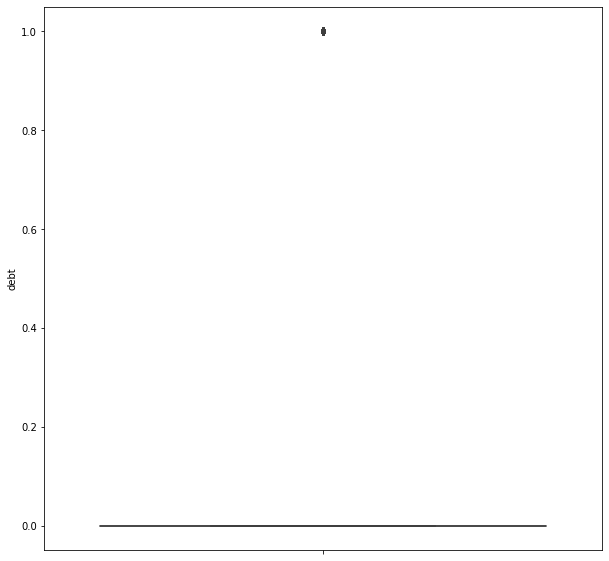

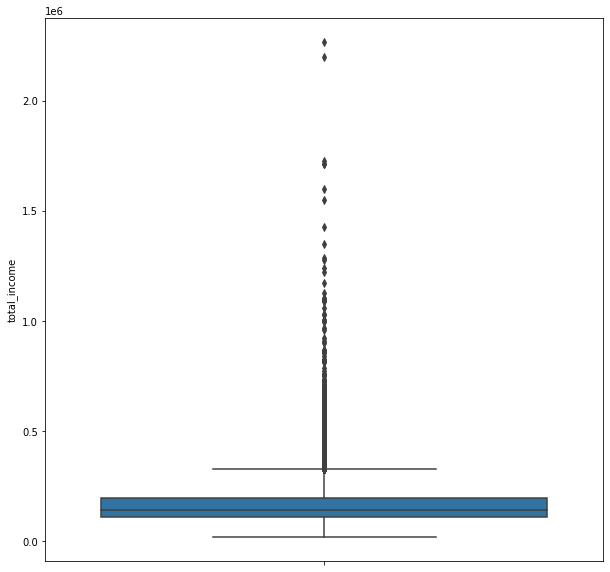

Всего удалено строк: 312


In [35]:
fields = ['children', 'days_employed', 'dob_years', 'debt', 'total_income', ]
for i in fields:                                              # проходим по списку параметров
    fig = plt.figure(figsize=(10,10))
    sns.boxplot(data = data, y=i)
    plt.show()
    
    del_quantity = len(data.index)                             # число строк в таблице
    q25 = data[i].quantile(0.25)                               # вычисляем 1-ую квантиль
    q75 = data[i].quantile(0.75)                               # вычисляем 3-ую квантиль                               
    minimum = q25 - 3 * (q75 - q25)                               # нижняя граница
    maximum = q75 + 3 * (q75 - q25)                               # верхняя граница
    df = data.loc[(data[i] >= minimum) & (data[i] <= maximum)].reset_index(drop=True)
print('Всего удалено строк: {}'.format(data.shape[0] - df.shape[0]))

### Категоризация данных
<a id="categorization"></a>

Из технического задания следует, что для исследования требуются следующие данные: "debt" (имел ли задолженность по возврату кредитов), "children" (количество детей в семье), "family_status" (семейное положение), "purpose" (цель получения кредита) и "total_income" (ежемесячный доход).

***Категоризация данных столбца "debt" (имел ли задолженность по возврату кредитов)***
<a id="categorization_debt"></a>

Данные столбца "debt" (имел ли задолженность по возврату кредитов) принимают значения "0" и "1". Такой формат данных пригоден для проведения анализа.

***Категоризация данных столбца "children" (количество детей в семье)***
<a id="categorization_children"></a>

Определяем число заемщиков для каждого количества детей:

In [36]:
df['children'].value_counts()

0    13957
1     4799
2     2011
3      321
4       40
5        9
Name: children, dtype: int64

В виду небольшого количества заемщиков с количеством детей 3, 4 и 5 целесообразно объединить объединить их в одну группу.  
Создаем в таблице столбец "children_id" с соответствующей классификацией заемщиков по количеству детей:

In [37]:
df.loc[df['children'] < 3, 'children_id'] = df['children']
df.loc[df['children'] >= 3, 'children_id'] = 3
df['children_id'] = df['children_id'].astype('uint8')
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_id
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,1
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,1
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,0
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,3
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,0
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,0
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,0
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование,0
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы,2
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи,0


***Категоризация данных столбца "family_status" (семейное положение)***
<a id="categorization_family_status"></a>

Данные столбца "family_status" (семейное положение) уже классифицированы: каждому значению присвоен соответствующий индекс в столбце "family_status_id" (идентификатор семейного положения).  
Выводим на экран список соответствия столбцов "family_status_id" (идентификатор семейного положения) и "family_status" (семейное положение):

In [38]:
family_index = df[['family_status_id', 'family_status']]
family_index = family_index.drop_duplicates().sort_values(by='family_status_id').reset_index(drop=True)
family_index

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


***Категоризация данных столбца "purpose" (цель получения кредита)***
<a id="categorization_purpose"></a>

В пункте 2.5 выделены 4 цели кредита: "недвижимость", "автомобиль", "образование" и "свадьба". Создаем в таблице "df" столбец "purpose_final" и заполняем его этими значениями в соответствии с данными столбца "purpose" (цель получения кредита):

In [39]:
def purpose_klass(row):
    lemmas = m.lemmatize(row)
    for i in lemmas:
        if (i == 'недвижимость' or i == 'жилье'):
            return('недвижимость')
        elif i == 'свадьба':
            return('свадьба')
        elif i == 'автомобиль':
            return('автомобиль')
        elif i == 'образование':
            return('образование')
df['purpose_final'] = df['purpose'].apply(purpose_klass).astype('category')

Выводим на экран первые 5 строк таблицы "df" и проверяем заполнение столбца "purpose_final":

In [40]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_id,purpose_final
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,1,недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,1,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,0,недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,3,образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,0,свадьба


***Категоризация данных столбца "total_income" (ежемесячный доход)***
<a id="categorization_total_income"></a>

Значения ежемесячного дохода лежат в широком диапазоне. Разбиваем его на меньшие диапазоны с шагом 10000 и определяем количество клиентов в каждом из них:

In [41]:
step = 10000                                                  # шаг периода
min_period = 0                                                # нижняя граница периода                                        
step_number = (df['total_income'].max() + step) // step     # количество шагов - (максимальный доход + шаг) // шаг
for i in range(step_number):                                  # цикл по количеству шагов
    max_period = min_period + step                            # верхняя граница периода
    clients = df.loc[df['total_income'] > min_period]     # если доход выше нижней границы периода, сохраняем строку                                    # переопределяем n в верхнюю границу периода
    # если доход ниже верхней границы, сохраняем строку                                                            
    clients = clients.loc[clients['total_income'] <= max_period, 'total_income'].count() 
    print('{}-{}: {}'.format(min_period, max_period, clients))
    min_period += step                                        # задаем нижнюю границу следующего периода

0-10000: 0
10000-20000: 0
20000-30000: 22
30000-40000: 103
40000-50000: 247
50000-60000: 432
60000-70000: 665
70000-80000: 801
80000-90000: 1069
90000-100000: 1113
100000-110000: 1175
110000-120000: 1610
120000-130000: 1093
130000-140000: 1155
140000-150000: 2158
150000-160000: 1108
160000-170000: 1001
170000-180000: 1298
180000-190000: 671
190000-200000: 681
200000-210000: 563
210000-220000: 493
220000-230000: 489
230000-240000: 384
240000-250000: 316
250000-260000: 353
260000-270000: 315
270000-280000: 251
280000-290000: 234
290000-300000: 171
300000-310000: 132
310000-320000: 125
320000-330000: 121
330000-340000: 128
340000-350000: 115
350000-360000: 72
360000-370000: 65
370000-380000: 83
380000-390000: 54
390000-400000: 55
400000-410000: 58
410000-420000: 35
420000-430000: 32
430000-440000: 39
440000-450000: 31
450000-460000: 21


На основании полученных данных определяем диапазоны для классификации доходов. Для репрезентативности выборки примем, что в каждом диапазоне должно быть не менее 100 заемщиков.
Получаются следующие диапазоны:  
- 20000 - 400000 с шагом 20000;  
- 400000 и более.  

Добавляем в таблицу "df" столбец "incom_id", в котором содержатся индексы, соответствующие диапазонам доходов:

In [42]:
incom_start = 20000      #Начало первого периода
incom_finish = 400000    #Окончание первого периода
step = 20000             #Шаг в первом периоде


def income_class(income):
    if (income > incom_start and income <= incom_finish):              # если доход > 20000 и <= 200000                                              # шаг равен 20000
        income_period = income // step                                 # номер периода равен целому от деления дохода на шаг
        return income_period
    if (income > incom_finish):
        income_period = incom_finish // step
        return income_period
df['incom_id'] = df['total_income'].apply(income_class).astype('uint8')

Добавляем в таблицу "df" столбец "incom_range", в котором содержатся диапазоны доходов:

In [43]:
def incom_range(incom_id):
    period = (incom_finish - incom_start) // step                              # максимальный индекс в первом периоде (20000-400000)
    if incom_id <= period:                                                     # если индекс в первом периоде
        income_period = incom_id * step                                        # начало периода = номер периода * шаг
        income_str = '{}-{}'.format(income_period, income_period + step)       # сохраняем результат
        return income_str
    if (incom_id > period):
        income_str = '> {}'.format(incom_finish)
        return income_str
df['incom_range'] = df['incom_id'].apply(incom_range).astype('category')

Выводим на экран первые 5 строк таблицы "df":

In [44]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_id,purpose_final,incom_id,incom_range
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,1,недвижимость,12,240000-260000
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,1,автомобиль,5,100000-120000
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,0,недвижимость,7,140000-160000
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,3,образование,13,260000-280000
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,0,свадьба,7,140000-160000


Выводим на экран список соответствия столбцов "incom_id" и "incom_range":

In [45]:
incom_index = df[['incom_id', 'incom_range']]
incom_index = incom_index.drop_duplicates().sort_values(by='incom_id').reset_index(drop=True)
incom_index

,incom_id,incom_range
0,1,20000-40000
1,2,40000-60000
2,3,60000-80000
3,4,80000-100000
4,5,100000-120000
5,6,120000-140000
6,7,140000-160000
7,8,160000-180000
8,9,180000-200000
9,10,200000-220000


Выводим общую информацию о таблице:

In [46]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21137 entries, 0 to 21136
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   children          21137 non-null  uint8   
 1   days_employed     21137 non-null  uint32  
 2   dob_years         21137 non-null  uint8   
 3   education         21137 non-null  category
 4   education_id      21137 non-null  uint8   
 5   family_status     21137 non-null  category
 6   family_status_id  21137 non-null  uint8   
 7   gender            21137 non-null  category
 8   income_type       21137 non-null  category
 9   debt              21137 non-null  uint8   
 10  total_income      21137 non-null  uint32  
 11  purpose           21137 non-null  category
 12  children_id       21137 non-null  uint8   
 13  purpose_final     21137 non-null  category
 14  incom_id          21137 non-null  uint8   
 15  incom_range       21137 non-null  category
dtypes: category(7), uint32

***Вывод***  
Для исследования требуются значения "debt" (имел ли задолженность по возврату кредитов), "children" (количество детей в семье), "family_status" (семейное положение), "purpose" (цель получения кредита) и "total_income" (ежемесячный доход).

Значения "debt" (имел ли задолженность по возврату кредитов) являются целочисленными, лежат в небольшом диапазоне, поэтому не требуют классификации.  
По количеству детей заемщики распределены на следующие группы:
- группа "0" - бездетные;
- группа "1" - с одним ребенком;
- группа "2" - с двумя детьми;
- группа "3" - с тремя и более детьми.  

"family_status" (семейное положение) уже классифицировано индексими из столбца "family_status_id" (идентификатор семейного положения).  
Для классификации "purpose" (цель получения кредита) в таблицу "df" добавлен столбец "purpose_final", значения которого определены лемматизацией целей кредита.  
Для классификации "total_income" (ежемесячный доход) определены диапазоны доходов, им присвоены номера. Эти данные содержатся в столбцах "incom_range" и "incom_id" соответственно.  
За счет оптимизации типов данных объем используемой памяти снижен на 96% (с 11,3 МБ до 467.3 KB)

## Исследование зависимости просрочек платежей от характеристик заемщика
<a id="research"></a>

### Зависимость просрочек платежей от количества детей
<a id="children"></a>

Вычисляем долю заемщиков, имеющих просрочки по платежам, в зависимости от количества детей:

In [47]:
# создаем сводную таблицу "df_pivot_children" на основе таблицы "df"
df_pivot_children = df.pivot_table(index = 'children_id', values = 'debt', aggfunc = ['sum', 'count', 'mean'])
df_pivot_children

,sum,count,mean
,debt,debt,debt
children_id,,,
0,1051.0,13957,0.075303
1,442.0,4799,0.092103
2,191.0,2011,0.094978
3,31.0,370,0.083784


Строим соответствующую диаграмму:

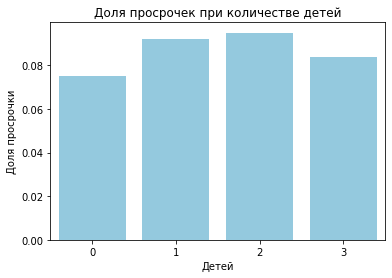

In [48]:
# создаем диаграмму на основе данных таблицы "df_pivot_children"
ax = sns.barplot(data=df_pivot_children, x = df_pivot_children.index, y = df_pivot_children['mean']['debt'], color='skyblue')
ax.set_title('Доля просрочек при количестве детей')      # присваиваем название оси диаграмме
ax.set_ylabel('Доля просрочки')                          # присваиваем название оси y
ax.set_xlabel('Детей')                                   # присваиваем название оси x
plt.show()

***Вывод***  
Доля просрочек при количестве детей лежит в диапазоне 0,075-0,094.  
В целом доля просрочек растет с увеличением количества детей (c 0,075 у бездетных до 0,094 у заемщиков с двумя детьми). Однако наблюдается ее снижение у многодетных заемщиков до 0,81.

### Зависимость просрочек платежей от семейного статуса
<a id="family_status"></a>

Выводим на экран список соответствия столбцов "family_status_id" (идентификатор семейного положения) и "family_status" (семейное положение):

In [49]:
family_index

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


Вычисляем долю заемщиков, имеющих просрочки по платежам в зависимости от семейного положения:

In [50]:
# создаем сводную таблицу "df_pivot_family" на основе таблицы "df"
df_pivot_family = df.pivot_table(index = 'family_status_id', values = 'debt', aggfunc = ['sum', 'count', 'mean'])
df_pivot_family

,sum,count,mean
,debt,debt,debt
family_status_id,,,
0,917.0,12135,0.075567
1,381.0,4111,0.092678
2,63.0,951,0.066246
3,83.0,1175,0.070638
4,271.0,2765,0.098011


Строим соответствующую диаграмму:

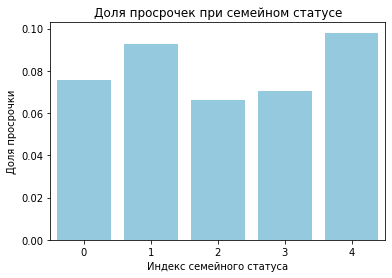

In [51]:
# создаем диаграмму на основе данных таблицы "df_pivot_family"
ax = sns.barplot(data=df_pivot_family, x = df_pivot_family.index, y = df_pivot_family['mean']['debt'], color='skyblue')
ax.set_title('Доля просрочек при семейном статусе')           # присваиваем название оси диаграмме
ax.set_ylabel('Доля просрочки')                               # присваиваем название оси y
ax.set_xlabel('Индекс семейного статуса')                     # присваиваем название оси x
plt.show()

***Вывод***  
Доля просрочек лежит в диапазоне 0,066-0,097.  
Наиболее низкая доля просрочки платежей наблюдается у категорий 0 (женат / замужем), 2 (вдовец / вдова), 3 (в разводе) - 0,066-0,075.  
Наименее надежны заемщики категорий 1 (гражданский брак) и 4 (не женат / не замужем) - 0,092 и 0,097 соответственно.  
Наиболее надежны в плане своевременного погашения кредита лица, состоящие или состоявшие в официальном браке, наименее - в официальном браке не состоявшие.

### Зависимость просрочек платежей от уровня дохода
<a id="incom"></a>

Выводим на экран список соответствия столбцов "incom_id" и "incom_range":

In [52]:
incom_index

,incom_id,incom_range
0,1,20000-40000
1,2,40000-60000
2,3,60000-80000
3,4,80000-100000
4,5,100000-120000
5,6,120000-140000
6,7,140000-160000
7,8,160000-180000
8,9,180000-200000
9,10,200000-220000


Вычисляем долю заемщиков, имеющих просрочки по платежам, в зависимости от уровня дохода:

In [53]:
# создаем сводную таблицу "df_pivot_incom" на основе таблицы "df"
df_pivot_incom = df.pivot_table(index = 'incom_id', values = 'debt', aggfunc = ['sum', 'count', 'mean'])
df_pivot_incom

,sum,count,mean
,debt,debt,debt
incom_id,,,
1,10.0,125,0.080000
2,39.0,679,0.057437
3,125.0,1466,0.085266
4,180.0,2182,0.082493
5,231.0,2785,0.082944
6,193.0,2248,0.085854
7,291.0,3266,0.089100
8,188.0,2299,0.081775


Строим соответствующую диаграмму:

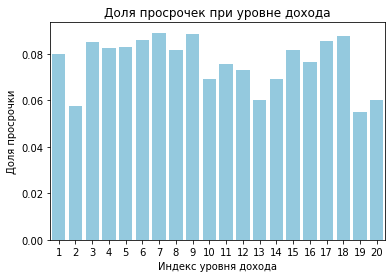

In [54]:
# создаем диаграмму на основе данных таблицы "df_pivot_incom"
ax = sns.barplot(data=df_pivot_incom, x = df_pivot_incom.index, y = df_pivot_incom['mean']['debt'], color='skyblue')
ax.set_title('Доля просрочек при уровне дохода')         # присваиваем название диаграмме
ax.set_ylabel('Доля просрочки')                          # присваиваем название оси y
ax.set_xlabel('Индекс уровня дохода')                    # присваиваем название оси x
plt.show() 

***Вывод***  
Доля просрочек лежит в диапазоне 0,055-0,089.  
Во всем диапазоне доходов доля просрочек в основном находятся около значения 0,08. Присутствую локальные снижения просрочек в диапазонах доходов 60000-80000, 200000-320000 и свыше 380000, однако однозначная тенденция не прослеживается.

### Зависимость просрочек платежей от целей кредита
<a id="purpose"></a>

Вычисляем долю заемщиков, имеющих просрочки по платежам, в зависимости от цели кредита:

In [55]:
# создаем сводную таблицу "df_pivot_purpose" на основе таблицы "df"
df_pivot_purpose = df.pivot_table(index = 'purpose_final', values = 'debt', aggfunc = ['sum', 'count', 'mean'])
df_pivot_purpose

,sum,count,mean
,debt,debt,debt
purpose_final,,,
автомобиль,397.0,4236,0.093720
недвижимость,772.0,10634,0.072597
образование,364.0,3958,0.091966
свадьба,182.0,2309,0.078822


Строим соответствующую диаграмму:

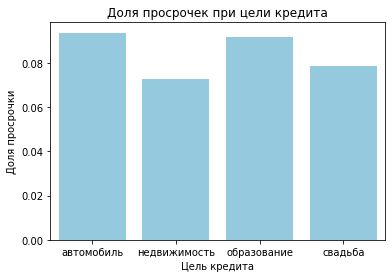

In [56]:
# создаем диаграмму на основе данных таблицы "df_pivot_purpose"
ax = sns.barplot(data=df_pivot_purpose, x = df_pivot_purpose.index, y = df_pivot_purpose['mean']['debt'], color='skyblue')
ax.set_title('Доля просрочек при цели кредита')    # присваиваем название диаграмме
ax.set_ylabel('Доля просрочки')                    # присваиваем название оси y
ax.set_xlabel('Цель кредита')                      # присваиваем название оси X
plt.show()

***Вывод***  
Доля просрочек лежит в диапазоне 0,072-0,093.  
По кредитам, цель которых "недвижимость" и "свадьба", просрочки минимальны - 0,072 и 0,078 соответственно.  
При целях кредита "автомобиль" и "образование" просрочки намного выше - 0,093 и 0,092.

## Общий вывод
<a id="result"></a>

В ходе исследования были исправлены некорректные данные исходной таблицы "df": устранены пропуски и дублирование; отрицательные значения количества детей и общего стажа заменены на положительные, исправлены значения пола заемщиков.  
В целях экономии ресурсов оптимизированы типы данных. В результате удалось добиться снижения объема используемой памяти для работы с таблицей на 96% (с 11,3 МБ до 474.2 KB).  
Посредством лемматизации классифицированы цели кредита.  

В результате исследования установлено, что существует зависимость между семейным положением и выплатами по кредиту в срок. Наименьшую долю просрочек имеют заемщики, состоящие или состоявшие в официальном браке:
- вдовец / вдова - 0,066;
- в разводе - 0,070;
- женат / замужем - 0,075.

Наибольшую долю просрочек имеют заемщики, не состоявшие в официальном браке:
- гражданский брак - 0,092;
- Не женат / не замужем - 0,097.  

Также выявлена зависимость между целями кредита и задержками выплат. Наиболее надежны лица, которым необходимы заемные средства на:
- недвижимость - 0,072;
- свадьбу - 0,078.  

Наименее надежны лица, которым необходимы заемные средства на:
- образование - 0,092;
- автомобиль - 0,093.  

Прослеживается тенденция к росту просрочек с увеличением количества детей (от 0,075 для бездетных до 0,094 для заемщиков с двумя детьми). Однако многодетные заемщики более ответственны - у них доля просрочек снижается до 0,081.  
Влияние уровня дохода на своевременность погашения кредита не выявлено: доля просрочек колеблется в диапазоне 0,055-0,089, однако однозначной тенденции в зависимости от дохода не прослеживается.
